In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'gray'
import plotly.express as px
import seaborn as sns

from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfr, ExtraTreesRegressor as etr
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor as lgb

import warnings
warnings.simplefilter('ignore')

In [3]:
train = pd.read_csv('train.csv')
train.time = pd.to_datetime(train.time)
train['time_id'] = ( ( (train.time.dt.dayofyear-1)*24*60 + train.time.dt.hour*60 + train.time.dt.minute ) /20 ).astype(int)
train = train.set_index('row_id', drop=True)
train.head()

,time,x,y,direction,congestion,time_id
row_id,,,,,,
0,1991-04-01,0,0,EB,70,6480
1,1991-04-01,0,0,NB,49,6480
2,1991-04-01,0,0,SB,24,6480
3,1991-04-01,0,1,EB,18,6480
4,1991-04-01,0,1,NB,60,6480


In [4]:
test = pd.read_csv('test.csv')
test.time = pd.to_datetime(test.time)
sbmin = pd.read_csv('sample_submission.csv')

In [5]:
train['dir_xy'] = train.direction.map({'EB':'[1,0]', 'NB':'[0,1]', 'SB':'[0,-1]', 'WB':'[-1,0]', 'NE':'[1,1]', 'SW':'[-1,-1]', 'NW':'[-1,1]', 'SE':'[1,-1]'})
loc_dir = train.groupby(['x', 'y']).dir_xy.unique().reset_index()
loc_dir['num_dir'] = loc_dir.dir_xy.apply(lambda x: len(x))
print(loc_dir)
print(f'Number of roadways: {loc_dir.num_dir.sum()}')

    x  y                                             dir_xy  num_dir
0   0  0                             [[1,0], [0,1], [0,-1]]        3
1   0  1                     [[1,0], [0,1], [0,-1], [-1,0]]        4
2   0  2                     [[1,0], [0,1], [0,-1], [-1,0]]        4
3   0  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
4   1  0     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
5   1  1                     [[1,0], [0,1], [0,-1], [-1,0]]        4
6   1  2     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
7   1  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
8   2  0                     [[1,0], [0,1], [0,-1], [-1,0]]        4
9   2  1  [[1,0], [0,1], [1,1], [-1,1], [0,-1], [1,-1], ...        8
10  2  2  [[1,0], [0,1], [1,1], [-1,1], [0,-1], [1,-1], ...        8
11  2  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
Number of roadways: 65


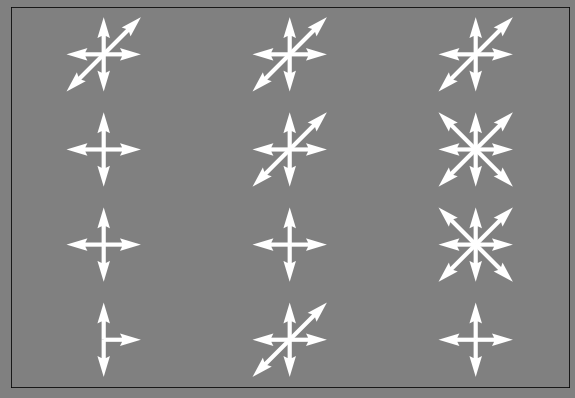

In [6]:
plt.figure(figsize=(10,7), facecolor='gray')
for idx, row in loc_dir.iterrows():
    origin = np.repeat(np.array([[row.x],[row.y]]),row.num_dir, axis=-1)
    V = np.array([eval(s) for s in row.dir_xy])
    plt.quiver(*origin, V[:,0], V[:,1], scale=15, color='white')
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,3.5)
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
train = train.drop('dir_xy',axis=1)

In [8]:
print(train.groupby(['x', 'y', 'direction']).time.count())
print(f'Total time instants within the observation period: {int(train.time_id.max() - train.time_id.min()+1)}')

x  y  direction
0  0  EB           13059
      NB           13059
      SB           13059
   1  EB           13059
      NB           13059
                   ...  
2  3  NB           13059
      NE           13059
      SB           13059
      SW           13059
      WB           13059
Name: time, Length: 65, dtype: int64
Total time instants within the observation period: 13140


In [9]:
time = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])

dfs = []
for group in train.groupby(['x', 'y', 'direction']):
    dfs.append(group[1].merge(time, on='time', how= 'right'))

train_new = pd.concat(dfs, axis=0).sort_values(['time', 'x', 'y', 'direction']).reset_index()
print(f'Missing row:\n{train_new.isna().sum()}')

Missing row:
index            0
time             0
x             5265
y             5265
direction     5265
congestion    5265
time_id       5265
dtype: int64


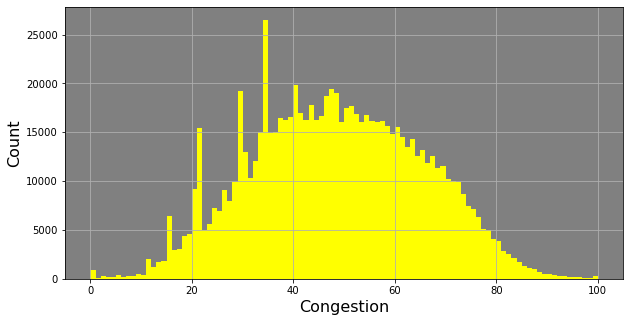

In [10]:
plt.figure(figsize=(10,5))
train.congestion.hist(bins=100, color='yellow')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

In [11]:
train['daytime_id'] = ( (train.time.dt.hour*60+train.time.dt.minute) /20 ).astype(int)

In [12]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.groupby(df.daytime_id).congestion.median().tolist()[-36:]

In [15]:
sbmin.congestion = test.congestion.round().astype(int).tolist()
sbmin.congestion[sbmin.congestion<0] = 0
sbmin.congestion[sbmin.congestion>100] = 100
sbmin.to_csv('dailyMedian.csv', index=False)
sbmin.head()

,row_id,congestion
0,848835,47
1,848836,34
2,848837,50
3,848838,26
4,848839,71


In [16]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train_new[(train_new.x == x) & (train_new.y==y) & (train_new.direction==direction)]
            df_new = pd.DataFrame()
            if df.shape[0]>0:                
                for idx, group in df.groupby(df.time.dt.dayofyear):
                    if len(group.congestion) == 72: # consider only days without missing data
                        df_new[f'day_{idx}'] = group.congestion.tolist()
            
                X_train = df_new[df_new.columns[:-1]][-36:]
                y_train = df_new[df_new.columns[-1]][-36:]

                X_test = df_new[df_new.columns[1:]][-36:]

                model = lr()
                model.fit(X_train, y_train)

                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = model.predict(X_test).tolist()

In [19]:
sbmin.congestion = test.congestion.round().astype(int).tolist()
sbmin.congestion[sbmin.congestion<0] = 0
sbmin.congestion[sbmin.congestion>100] = 100
sbmin.to_csv('DailyLinearRegression.csv', index=False)
sbmin.head()

,row_id,congestion
0,848835,46
1,848836,41
2,848837,50
3,848838,19
4,848839,66


In [29]:
# train.direction.unique()
df = train_new[(train_new.x == 0) & (train_new.y==0) & (train_new.direction=='EB')]